In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    precision_recall_curve, 
    f1_score, 
    accuracy_score,
    confusion_matrix
)

In [2]:
X, y = make_classification(
    n_samples=5000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_clusters_per_class=2,
    weights=[0.9, 0.1],  # imbalanced
    random_state=42
)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [4]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:, 1]

In [5]:
# Platt scaling (sigmoid)
platt = CalibratedClassifierCV(clf, method="sigmoid", cv=5)
platt.fit(X_train, y_train)
probs_platt = platt.predict_proba(X_test)[:, 1]

In [6]:
# Isotonic regression
isotonic = CalibratedClassifierCV(clf, method="isotonic", cv=5)
isotonic.fit(X_train, y_train)
probs_iso = isotonic.predict_proba(X_test)[:, 1]

In [7]:
def plot_precision_recall_vs_threshold(y_true, probs, label):
    precision, recall, thresholds = precision_recall_curve(y_true, probs)
    plt.plot(thresholds, precision[:-1], "b--", label=f"Precision ({label})")
    plt.plot(thresholds, recall[:-1], "g-", label=f"Recall ({label})")
    plt.xlabel("Threshold")
    plt.ylabel("Precision/Recall")
    plt.title("Precision-Recall vs Threshold")
    plt.legend()
    plt.grid(True)


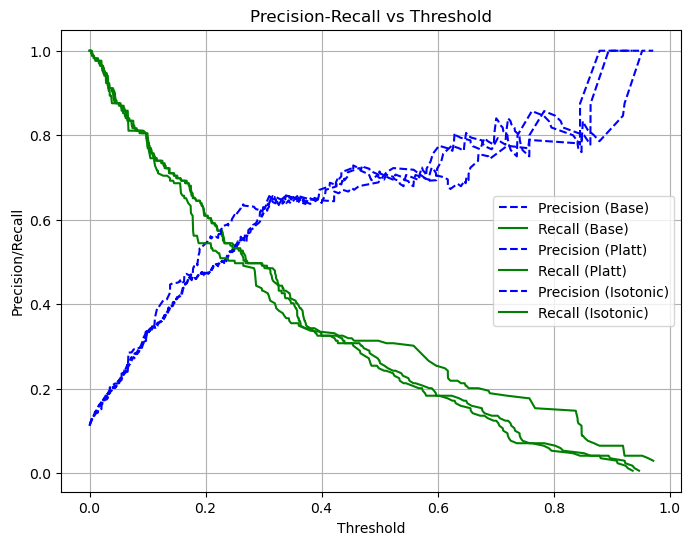

In [8]:
plt.figure(figsize=(8, 6))
plot_precision_recall_vs_threshold(y_test, probs, "Base")
plot_precision_recall_vs_threshold(y_test, probs_platt, "Platt")
plot_precision_recall_vs_threshold(y_test, probs_iso, "Isotonic")
plt.show()

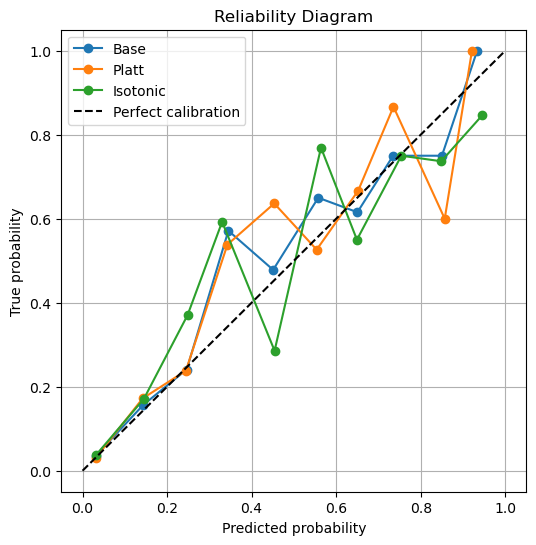

In [9]:
def plot_reliability(y_true, probs, label):
    prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=label)

plt.figure(figsize=(6, 6))
plot_reliability(y_test, probs, "Base")
plot_reliability(y_test, probs_platt, "Platt")
plot_reliability(y_test, probs_iso, "Isotonic")
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Reliability Diagram")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_test, probs_platt >= t) for t in thresholds]
best_t = thresholds[np.argmax(f1_scores)]

print(f"Best Threshold (by F1): {best_t:.2f}")
print(f"F1 Score: {max(f1_scores):.3f}")

Best Threshold (by F1): 0.31
F1 Score: 0.553


In [11]:
y_pred_best = (probs_platt >= best_t).astype(int)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_best):.3f}")


Confusion Matrix:
[[1288   43]
 [  88   81]]
Accuracy: 0.913
F1 Score: 0.553
